In [99]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import math
import torch
from torch import nn
import numpy as np 
from BelugaMultiplexer import *
from Beluga import *
import scipy
import matplotlib.pyplot as plt
import seaborn

""" 
class BelugaMultiplexer(nn.Module):
    def __init__(self):
        super(BelugaMultiplexer, self).__init__()
        
        self.model_one = nn.Sequential(
                nn.Conv1d(5,640, 8, padding = 3),
                nn.BatchNorm1d(640),
                nn.ReLU(),
                nn.Conv1d(640,640, 8, padding = 4),
                nn.BatchNorm1d(640),
                nn.ReLU())
        
        self.model_two = nn.Sequential(
             
                nn.Conv1d(640,1280, 8, dilation=4, padding= 14),
                nn.BatchNorm1d(1280),
                nn.ReLU(),
                nn.Conv1d(1280,1280, 8, dilation=4, padding= 14),
                nn.BatchNorm1d(1280),
                nn.ReLU())
                
        self.model_three = nn.Sequential(
            
                nn.Conv1d(1280,1280, 8, dilation=16, padding= 56),
                nn.BatchNorm1d(1280),
                nn.ReLU(),
                nn.Conv1d(1280,1280, 8, dilation=16, padding= 56),
                nn.BatchNorm1d(1280),
                nn.ReLU())
        
        
        self.model_four = nn.Sequential(
                #optional (may improve performance)
                nn.Conv1d(1280, 1280, 8, dilation=64, padding= 224),
                nn.BatchNorm1d(1280),
                nn.ReLU(),
                nn.Conv1d(1280,1280, 8, dilation=64, padding= 224),
                nn.BatchNorm1d(1280),
                nn.ReLU())
        
        
        self.model_five = nn.Sequential(
                nn.Conv1d(1280,1280, 8, dilation=16, padding= 56),
                nn.BatchNorm1d(1280),
                nn.ReLU(),
                nn.Conv1d(1280,1280, 8, dilation=16, padding= 56),
                nn.BatchNorm1d(1280),
                nn.ReLU())
        
        
        self.model_six = nn.Sequential(
                nn.Conv1d(1280,1280, 8, dilation=4, padding= 14),
                nn.BatchNorm1d(1280),
                nn.ReLU(),
                nn.Conv1d(1280,1280, 8, dilation=4, padding= 14),
                nn.BatchNorm1d(1280),
                nn.ReLU())
            
        self.model_final = nn.Sequential(               
                nn.Conv1d(1280,2002, 1, dilation=1, padding=0),
                nn.BatchNorm1d(2002),
                nn.ReLU(), 
                nn.Conv1d(2002,2002, 1, dilation=1, padding=0))
        
        
            
        

    def forward(self, x):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        encoding = torch.cat((torch.arange(0,1,0.001), torch.arange(1,0, -0.001))).unsqueeze(0).to(device)
        encoding = encoding.repeat( 1, 1)
        x = torch.cat((x, encoding), dim = 0).unsqueeze(0)
        print(x.shape)
        l_one_output = self.model_one(x)
        l_two_output = self.model_two(l_one_output)
        l_three_output = self.model_three(l_two_output)
        l_four_output = self.model_four(l_three_output)
        l_five_output = self.model_five(l_four_output)
        l_six_output = self.model_six(l_three_output + l_five_output )
        final_out = self.model_final(l_two_output + l_six_output)
        print(final_out.shape)
     
        return final_out

"""
def log_fold(alt, ref):
    """
    Returns the log fold of a,b
    
    returns log(((alt+1e-6) * (1-ref+1e-6)) /((1-alt+1e-6) * (ref+1e-6)) 
    """
    e = 10**(-6)
    top = (alt + e)*(1 - ref + e)
    bot = (1 - alt + e) * (ref + e)
    return np.log(top/bot)

B = Beluga()
B.load_state_dict(torch.load('../resources/deepsea.beluga.pth'))
B.eval().cuda()

BM = BelugaMultiplexer()
#BM = nn.DataParallel(BM)

BM.load_state_dict(torch.load("../comparison/weights/BelugaMultiplexerWeights.pth"))
#BM.load_state_dict(torch.load('../singleMut/posEncode.pth'))
BM.eval().cuda()
print()

In [100]:
size = 10

x = torch.load('input_list')[:size]
y = torch.load("seq_list_strings")[:size]

In [101]:
BM_outputs = torch.zeros((size, 2000, 4, 2002))

for i in range(size):
    BM_outputs[i] = BM(x[i].unsqueeze(0).cuda()).detach().cpu().transpose(1,3)
    
print(BM_outputs.shape)

torch.Size([10, 2000, 4, 2002])


In [4]:
A = BM_outputs.numpy()[0]
B = Beluga_pred.numpy()[0]
ref = x[0]

ref.shape

NameError: name 'Beluga_pred' is not defined

In [5]:
A = BM_outputs.numpy()
B = Beluga_pred.numpy()
ref = x.transpose(1,2).cpu().numpy()


###for each of the 2002 profiles, we need to test every threshold
for thresh in np.linspace(0, 0.01, 5):
    corrs_per_thresh = []
    
    corrs_per_profile = torch.zeros((2002))
    for i in range(2002):
        corr = batch_correlation(A[ (np.abs(A[:, :, :, i]) > thresh) * (ref != 1) ,i], B[ (np.abs(A[:, :, :, i]) > thresh) * (ref != 1) ,i])
        new_size = A[ (np.abs(A[:, :, :, i]) > thresh) * (ref != 1) ,i].shape[0]
        old_size = A[(ref != 1),i].flatten().shape[0]
        
        corrs_per_profile[i] = corr

        #print(round(corr,3), " Percent of Original : ", str(round(new_size/old_size, 3) * 100), "%")
    
    corrs_per_thresh.append(corrs_per_profile.mean())




    



NameError: name 'Beluga_pred' is not defined

# THIS SECTION BELOW IS FOR HEATMAP PLOTTING













### Load Models and Inputs

In [68]:
B = Beluga()
B.load_state_dict(torch.load('../resources/deepsea.beluga.pth'))
B.eval().cuda()

BM = BelugaMultiplexer()
BM.load_state_dict(torch.load("../comparison/weights/BelugaMultiplexerWeights.pth"))
BM.eval().cuda()

size = 10

x = torch.load('input_list')[:size].cuda()  # x[i] is a 4x2000 reference sequence
y = torch.load("seq_list_strings")[:size] #y[i] the un-encoded version of x[i], it is a 'agct' - string

In [69]:
q = 5
### Get Multiplexer Prediction on x[0]
multiplexer_pred = BM(x[q].unsqueeze(0).cuda()).detach().cpu() #output shape is [1, 2002, 4, 2000]


###Get Beluga Prediction

#First get all possible mutations of y[0] and encode them, mutates is of shape [8k, 4, 2k]
mutates = mutate_seq(y[q])


batch_size = 96
beluga_output = []
for i in range(int(math.floor(8000/batch_size)) + 1):
    
    #Create a batch of inputs
    batched_input = mutates[i*batch_size : (i+1)*batch_size, :, :].cuda() 

    
    #Pass the batched_input through the Beluga model and append to array
    beluga_output.append(B(batched_input.cuda()).cpu().detach())   

#stack the alternative array
beluga_output_alt = torch.vstack(beluga_output)


#define reference 
reference_prediction = B(x[q].unsqueeze(0))

###Find the log_fold change 
Beluga_output = log_fold(beluga_output_alt.detach().cpu(), reference_prediction.detach().cpu())

## Correlation Tests

In [54]:
A = torch.load("../comparison/predictions/Beluga_predictions_small")
B = torch.load("../comparison/predictions/Multiplexer_predictions_small")

B = B.transpose(2,3).reshape(-1, 2002, 8000).transpose(1,2)

for j in range(1):
    
    A_temp = A
    B_temp = B
    print(corr(A_temp.numpy().flatten(), B_temp.numpy().flatten(), np.abs(A_temp.numpy().flatten())))




0.9013641


## Plotting

multiplexer prediction has shape [1, 2002, 4, 2000] \
Beluga_output has shape [8000, 2002]

In [92]:
A = multiplexer_pred[0].transpose(1,2).reshape(2002, 8000).T.numpy()
A.dtype
B = Beluga_output



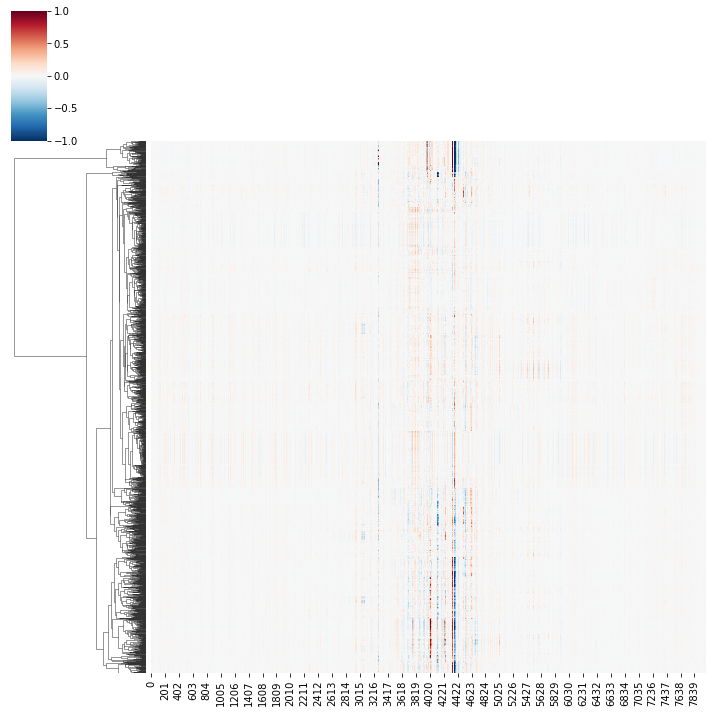

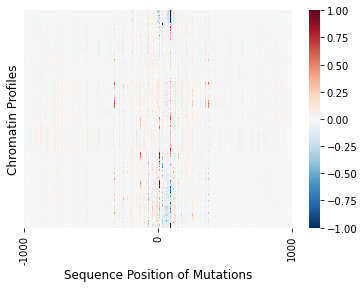

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [96]:
plt.rcParams['ps.fonttype'] = 42

c = seaborn.clustermap(A.T, row_cluster=True, col_cluster=False,cmap = "RdBu_r", center=0, vmax = 1, vmin = -1, yticklabels=False, rasterized=True )
roworder = c.dendrogram_row.reordered_ind

plt.figure()

temp = A.T[roworder]
d = seaborn.heatmap(temp, cmap = "RdBu_r", center=0, vmax = 1, vmin = -1, yticklabels=False, rasterized=True )

d.set(yticklabels=[])
d.set_xticks([0,4000,8000])
d.set_xticklabels([-1000, 0, 1000])
d.tick_params(left=False) 


plt.ylabel("Chromatin Profiles", fontsize = 12)
plt.xlabel("Sequence Position of Mutations", fontsize = 12)
plt.savefig('trial.pdf', bbox_inches = 'tight', format = "pdf", dpi = 600)
plt.show()
plt.figure()

<Figure size 432x288 with 0 Axes>

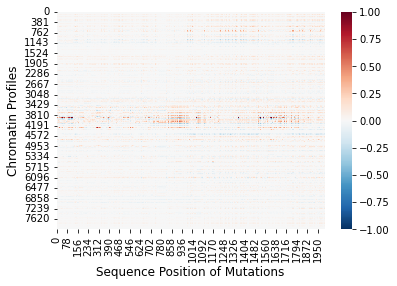

<Figure size 432x288 with 0 Axes>

In [33]:
plt.rcParams['ps.fonttype'] = 42

c = seaborn.heatmap(B, cmap = "RdBu_r", center=0, vmax = 1, vmin = -1, rasterized=True )


plt.ylabel("Chromatin Profiles", fontsize = 12)
plt.xlabel("Sequence Position of Mutations", fontsize = 12)
plt.savefig('cmap4.pdf', bbox_inches = 'tight', format = "pdf", dpi = 600)  
plt.figure()



<AxesSubplot:>

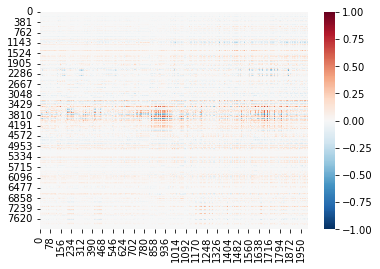

In [26]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


corr(A.numpy().flatten(), B.numpy().flatten(), np.abs(A.numpy().flatten()))

#pearsonr(A.flatten() + 1,B.flatten() + 1)

0.9592307

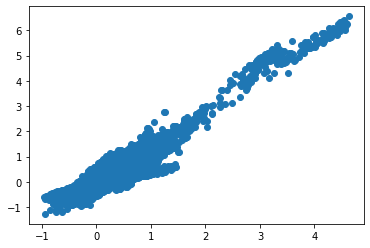

In [235]:
plt.scatter(A.flatten(), B.flatten(), color = "gray", s = .5, rasterized=True)

In [240]:
x = torch.tensor([1,2,3,4])
y = torch.tensor([12,512,61,14])

pearsonr(np.exp(x),np.exp(y))[0]

-0.3926562924446697

/home2/s202726/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


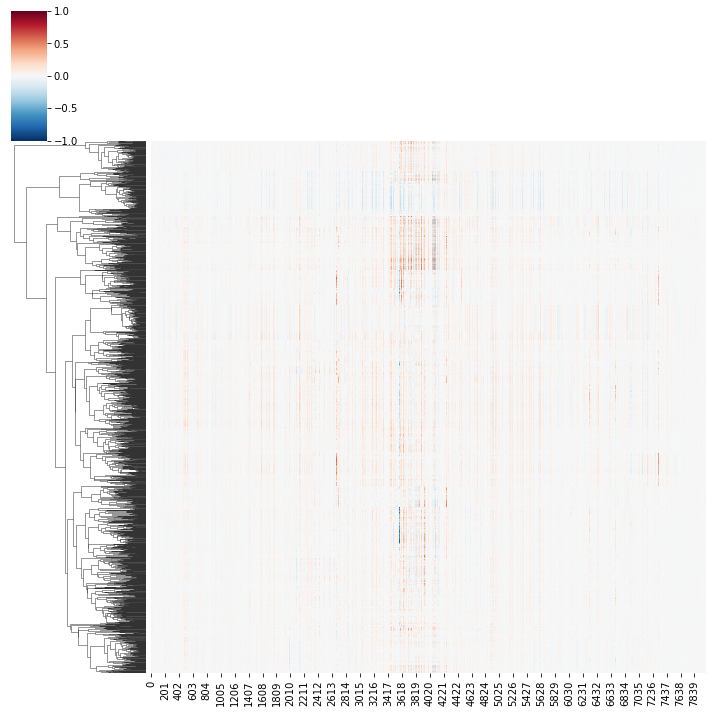

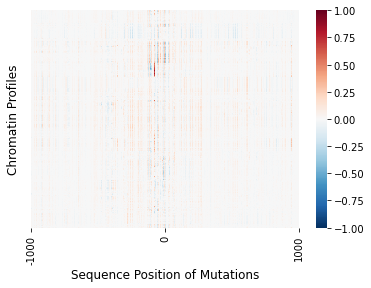

<Figure size 432x288 with 0 Axes>

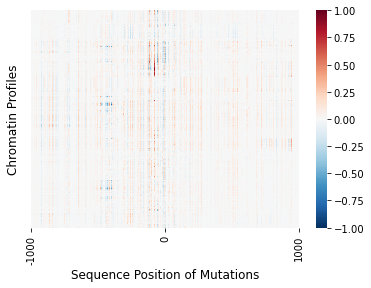

<Figure size 432x288 with 0 Axes>

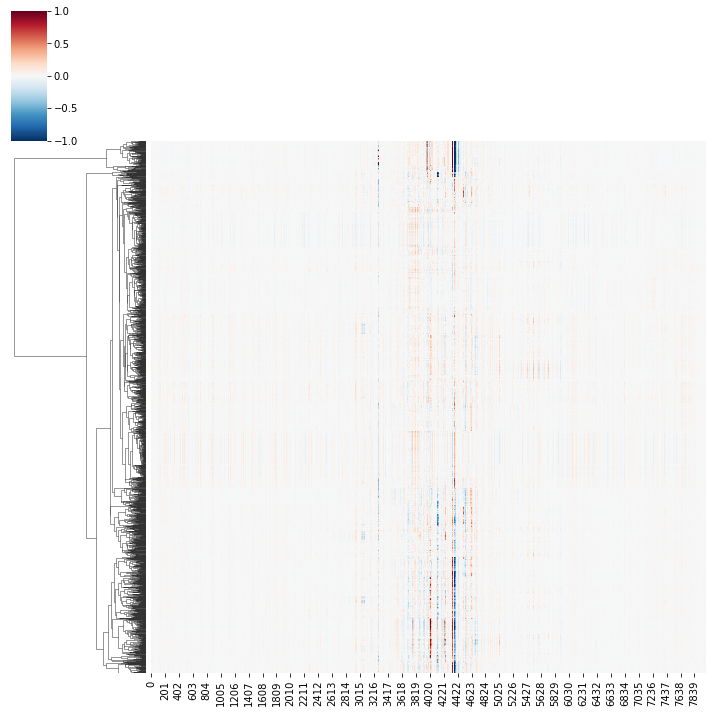

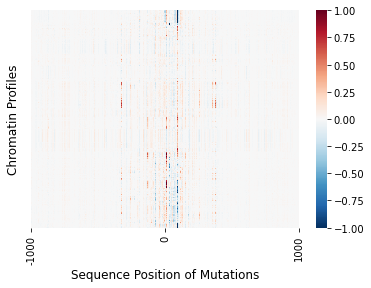

<Figure size 432x288 with 0 Axes>

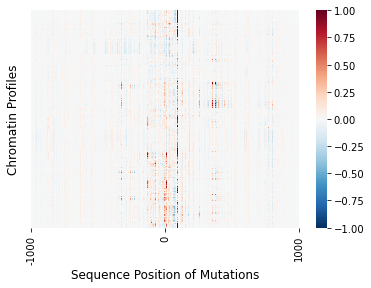

<Figure size 432x288 with 0 Axes>

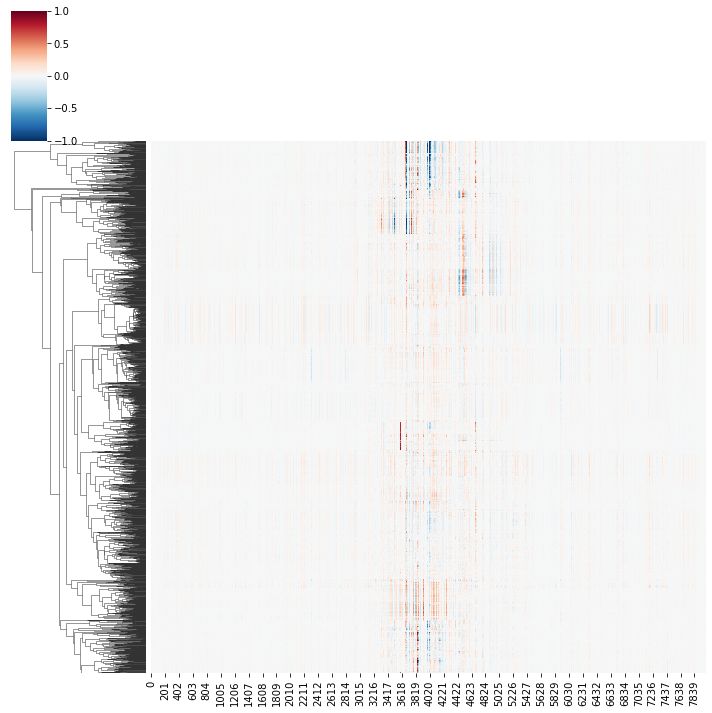

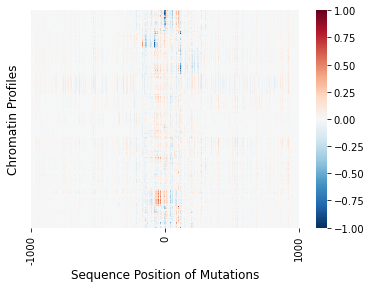

<Figure size 432x288 with 0 Axes>

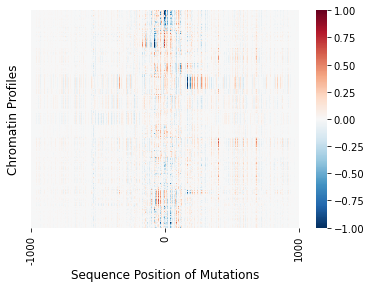

<Figure size 432x288 with 0 Axes>

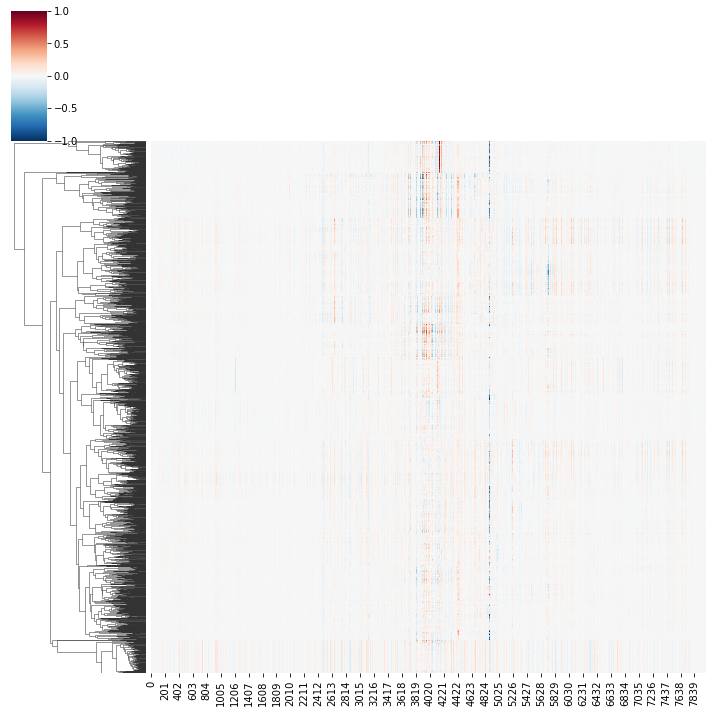

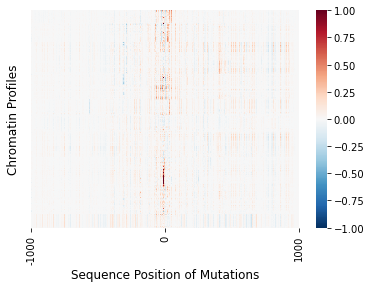

<Figure size 432x288 with 0 Axes>

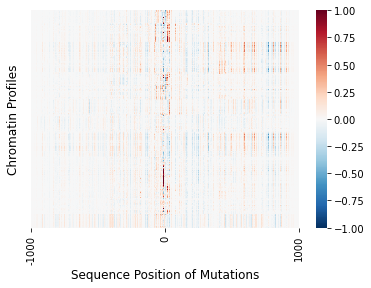

<Figure size 432x288 with 0 Axes>

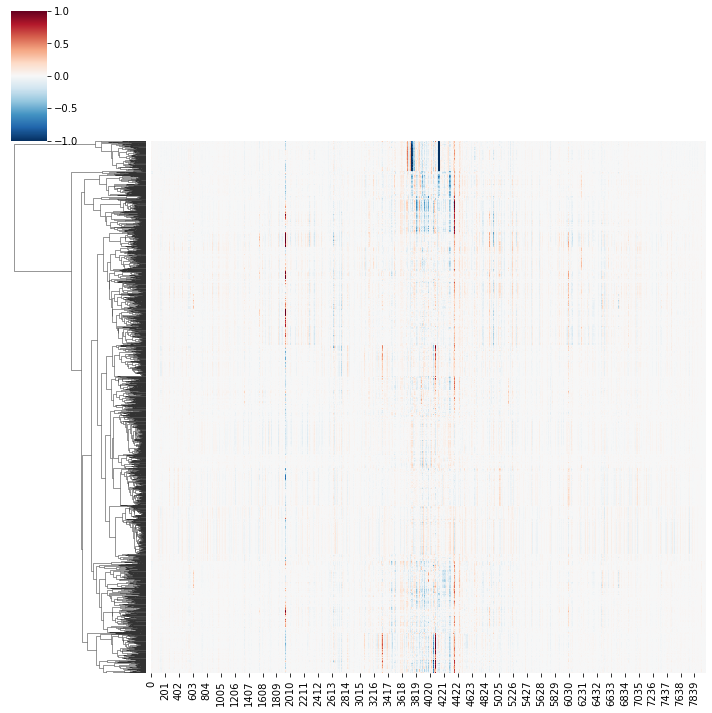

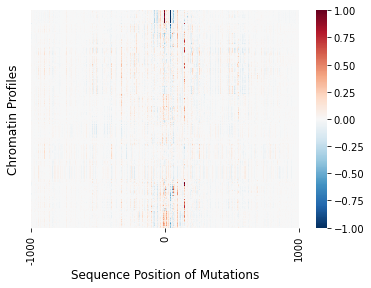

<Figure size 432x288 with 0 Axes>

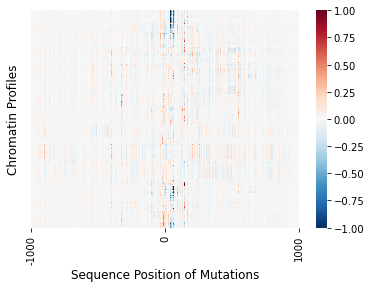

<Figure size 432x288 with 0 Axes>

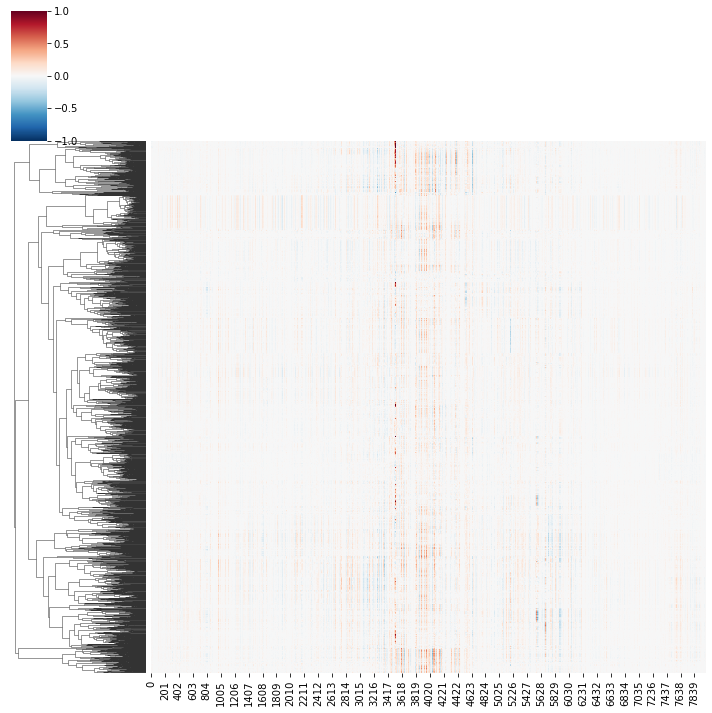

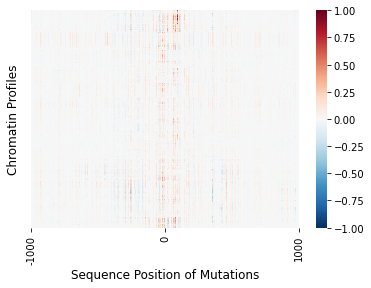

<Figure size 432x288 with 0 Axes>

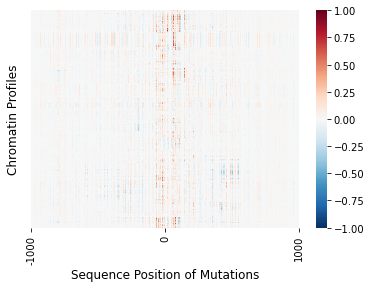

<Figure size 432x288 with 0 Axes>

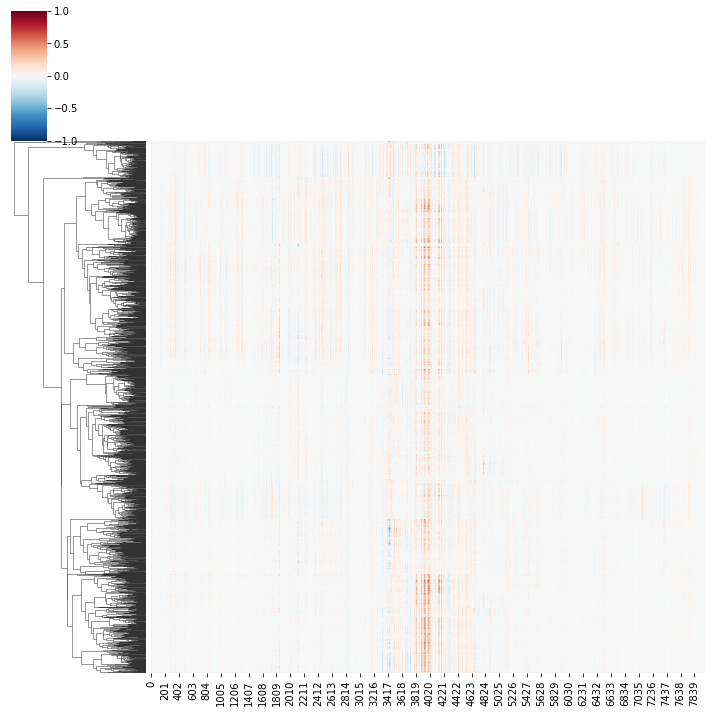

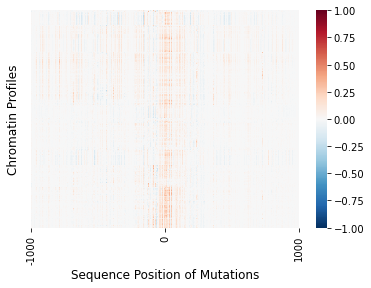

<Figure size 432x288 with 0 Axes>

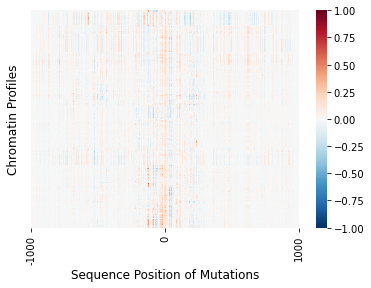

<Figure size 432x288 with 0 Axes>

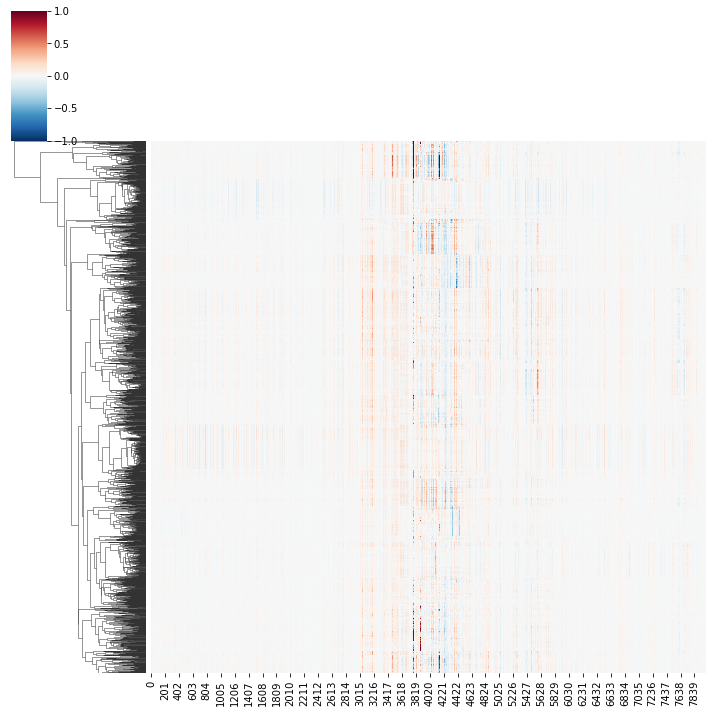

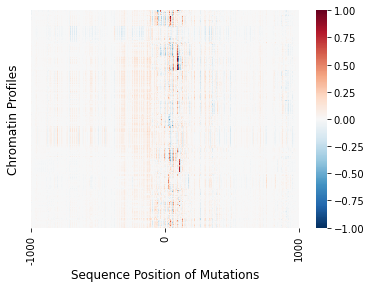

<Figure size 432x288 with 0 Axes>

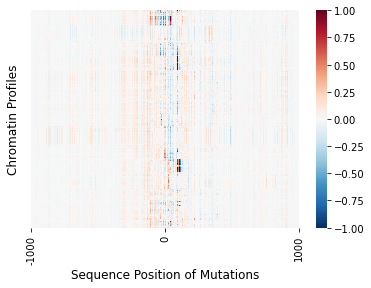

<Figure size 432x288 with 0 Axes>

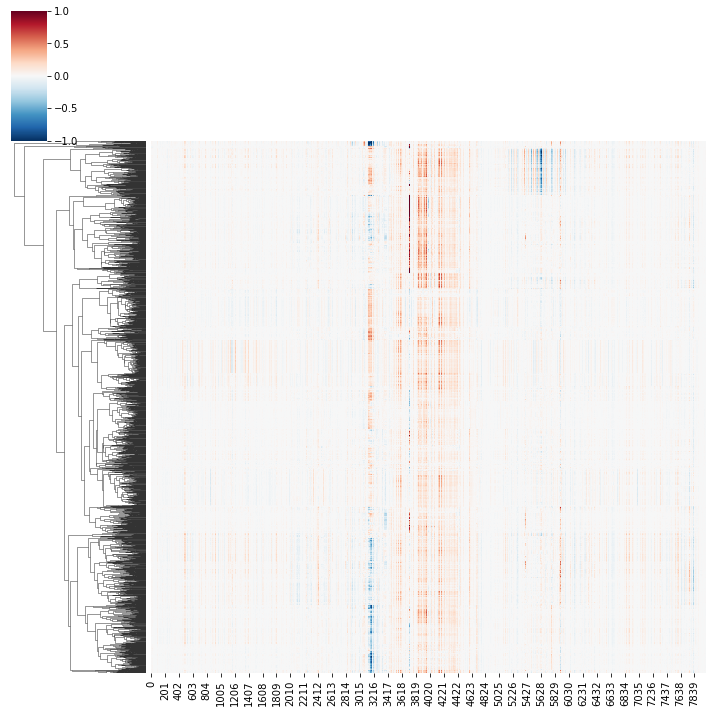

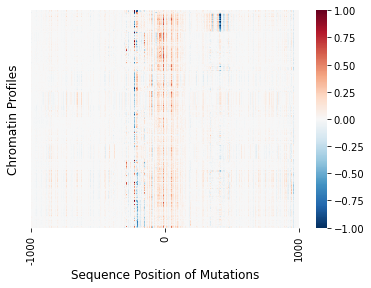

<Figure size 432x288 with 0 Axes>

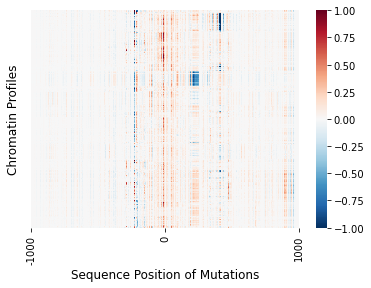

<Figure size 432x288 with 0 Axes>

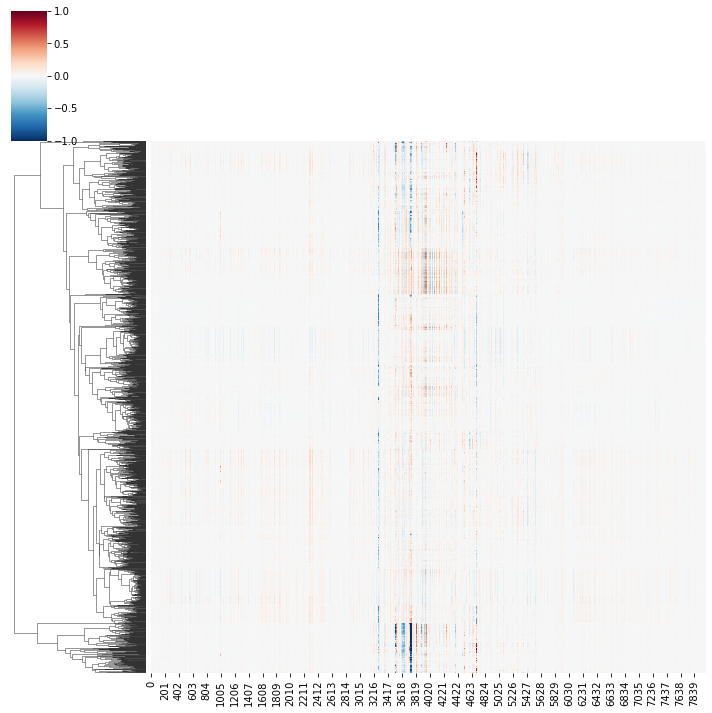

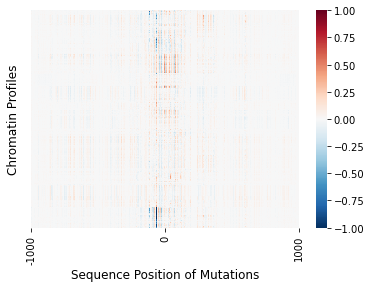

<Figure size 432x288 with 0 Axes>

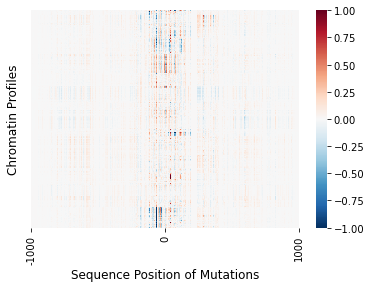

<Figure size 432x288 with 0 Axes>

In [102]:
BE = Beluga()
BE.load_state_dict(torch.load('../resources/deepsea.beluga.pth'))
BE.eval().cuda()

BM = BelugaMultiplexer()
BM.load_state_dict(torch.load("../comparison/weights/BelugaMultiplexerWeights.pth"))
BM.eval().cuda()

size = 50

x = torch.load('input_list')[:size].cuda()  # x[i] is a 4x2000 reference sequence
y = torch.load("seq_list_strings")[:size] #y[i] the un-encoded version of x[i], it is a 'agct' - string

count = 1
count2 = 2
for q in range(0, 49, 5):
    ### Get Multiplexer Prediction on x[0]
    multiplexer_pred = BM(x[q].unsqueeze(0).cuda()).detach().cpu() #output shape is [1, 2002, 4, 2000]


    ###Get Beluga Prediction

    #First get all possible mutations of y[0] and encode them, mutates is of shape [8k, 4, 2k]
    mutates = mutate_seq(y[q])


    batch_size = 96
    beluga_output = []
    for i in range(int(math.floor(8000/batch_size)) + 1):

        #Create a batch of inputs
        batched_input = mutates[i*batch_size : (i+1)*batch_size, :, :].cuda() 


        #Pass the batched_input through the Beluga model and append to array
        beluga_output.append(BE(batched_input.cuda()).cpu().detach())   

    #stack the alternative array
    beluga_output_alt = torch.vstack(beluga_output)


    #define reference 
    reference_prediction = BE(x[q].unsqueeze(0))

    ###Find the log_fold change 
    Beluga_output = log_fold(beluga_output_alt.detach().cpu(), reference_prediction.detach().cpu())


    A = multiplexer_pred[0].transpose(1,2).reshape(2002, 8000).T
    B = Beluga_output



    plt.rcParams['ps.fonttype'] = 42
    
    temp = seaborn.clustermap(A.T.numpy(), row_cluster=True, col_cluster=False,cmap = "RdBu_r", center=0, vmax = 1, vmin = -1, yticklabels=False, rasterized=True )
    roworder = temp.dendrogram_row.reordered_ind

    plt.figure()




    c = seaborn.heatmap(A.T[roworder], cmap = "RdBu_r", center=0, vmax = 1, vmin = -1, rasterized=True )
    c.set(yticklabels=[])
    c.set_xticks([0,4000,8000])
    c.set_xticklabels([-1000, 0, 1000])
    c.tick_params(left=False) 


    plt.ylabel("Chromatin Profiles", fontsize = 12)
    plt.xlabel("Sequence Position of Mutations", fontsize = 12)
    plt.savefig('cmap' + str(count) + '.pdf', bbox_inches = 'tight', format = "pdf", dpi = 600)  
    plt.figure()



    plt.rcParams['ps.fonttype'] = 42
    
    
    plt.figure()

    c = seaborn.heatmap(B.T[roworder], cmap = "RdBu_r", center=0, vmax = 1, vmin = -1, rasterized=True )
    c.set(yticklabels=[])
    c.set_xticks([0,4000,8000])
    c.set_xticklabels([-1000, 0, 1000])
    c.tick_params(left=False) 


    plt.ylabel("Chromatin Profiles", fontsize = 12)
    plt.xlabel("Sequence Position of Mutations", fontsize = 12)
    plt.savefig('cmap' + str(count2) + '.pdf', bbox_inches = 'tight', format = "pdf", dpi = 600)  
    plt.figure()
                
    count += 2
    count2 += 2

